## TOC
 1. load data and libs 
 2. preprocessing data [jump](#prepros)
     1. transform data to daily deaths (not cumulated)
     2. split test/train
     3. scale data
     4. create sequences of x days
     5. convert data to torch vectors/tensors
 3. build model [jump](#build)
 4. train model [jump](#train)
 5. validate model [jump](#vali)
 6. make prediction [jump](#pred)

## 1. load data and libs

In [1]:
import torch
from torch import optim, nn

torch.manual_seed(1)

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import mlflow

import time

In [ ]:
## model config
    #TODO


In [2]:
file_cases = "../01_data/covid_time_series_cases_transformed.csv"
file_deaths = "../01_data/covid_time_series_deaths_transformed.csv"


ts_cases = pd.read_csv(file_cases, index_col=0)
ts_deaths = pd.read_csv(file_deaths, index_col=0)

In [3]:
ts_deaths

,deaths
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-06-25,8940
2020-06-26,8965
2020-06-27,8968
2020-06-28,8968


## 2. preprocessing test <a id="prepros"></a>

### 2.a transform data to daily deaths (not cumulated)

In [4]:
ts_deaths_diff = ts_deaths.diff()

In [5]:
ts_deaths_diff

,deaths
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2020-06-25,12.0
2020-06-26,25.0
2020-06-27,3.0
2020-06-28,0.0


In [6]:
ts_deaths_diff = ts_deaths_diff.fillna(0)

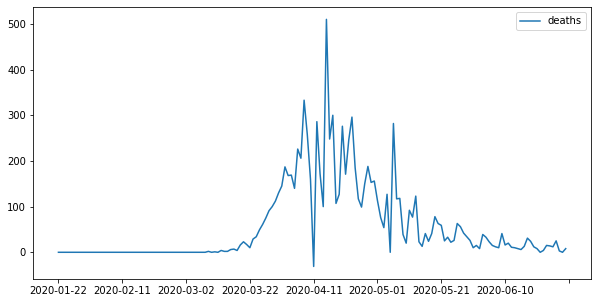

In [7]:
ts_deaths_diff.plot(figsize=(10,5))

### 2.b train test split

In [8]:
ts_deaths_diff.shape ## ts of 160 records split into 90%/10% train/test parts

(160, 1)

In [9]:
train_size = int(len(ts_deaths_diff) * 0.9) # 144 records for training and 16 for validation

In [10]:
train = ts_deaths_diff.iloc[:train_size]
test = ts_deaths_diff.iloc[train_size:]

In [11]:
train.shape

(144, 1)

In [12]:
test.shape

(16, 1)

### 2.c scale data

In [13]:
scaler = MinMaxScaler()

scaler = scaler.fit(train)

In [14]:
scaler.transform(train)

array([[0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.05730129],
       [0.060

In [15]:
train_scaled = scaler.transform(train) 
test_scaled = scaler.transform(test) 

In [16]:
print("train min", train_scaled.min())
print("train max", train_scaled.max())
print("train std", train_scaled.std())

print("test min", test_scaled.min())
print("test max", test_scaled.max())
print("test std", test_scaled.std())


train min 0.0
train max 0.9999999999999999
train std 0.16501537475159747
test min 0.05730129390018484
test max 0.11460258780036968
test std 0.01600744640935093


### 2.d create sequences of x days

In [17]:
def create_sequences(data, TIME_STEPS):
    X_sequences, Y_sequences = [], []

    for i in range(len(data) - TIME_STEPS):
        seq_x = data[i: (i + TIME_STEPS)]
        seq_y = data[i + TIME_STEPS]

        X_sequences.append(seq_x)
        Y_sequences.append(seq_y)

    return np.array(X_sequences), np.array(Y_sequences)

In [18]:
time_steps = 10

train_seq_x, train_seq_y = create_sequences(train_scaled, time_steps)
test_seq_x, test_seq_y = create_sequences(test_scaled, time_steps)

In [19]:
display(train_seq_x[-2:])

array([[[0.07208872],
        [0.12939002],
        [0.11829945],
        [0.09981516],
        [0.08502773],
        [0.07948244],
        [0.07578558],
        [0.13308688],
        [0.08687616],
        [0.09426987]],

       [[0.12939002],
        [0.11829945],
        [0.09981516],
        [0.08502773],
        [0.07948244],
        [0.07578558],
        [0.13308688],
        [0.08687616],
        [0.09426987],
        [0.07763401]]])

In [20]:
display(train_seq_y[-2:])

array([[0.07763401],
       [0.07578558]])

In [21]:
train_seq_y.shape, train_seq_x.shape

((134, 1), (134, 10, 1))

In [22]:
test_seq_y.shape, test_seq_x.shape

((6, 1), (6, 10, 1))

### 2.e convert data to torch vectors/tensors

In [23]:
x_train = torch.from_numpy(train_seq_x).float()
y_train = torch.from_numpy(train_seq_y).float()

x_test = torch.from_numpy(test_seq_x).float()
y_test = torch.from_numpy(test_seq_y).float()

In [24]:
x_train.shape

torch.Size([134, 10, 1])

## 3. build model <a id="build"></a>- blueprint pytorch: [LSTMtagger Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

In [25]:
class CoronaDeathsPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CoronaDeathsPredictor, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        dropout_ratio = 0.5
        
        self.lstm = nn.LSTM(input_size = self.n_features,
                            hidden_size = self.n_hidden,
                            num_layers = self.n_layers,
                           dropout=dropout_ratio)
        
        ## define output layer.
        ## in this case we want to predict the deaths on the next day, 
        ## based on the deaths of the last n days (sequence).
        ## for this we need a linear layer after the LSTM operations to aggregate the
        ## hidden state outputs
        
        self.linear = nn.Linear(in_features = n_hidden, out_features = 1)
        
    
    ## after each step we will reset the hidden states, because this model predicts only
    ## death numbers based on the sequence of n days.
    
    ## to make this model "stateless"
    def reset_hidden_state(self):
        
        reset_hidden_states = torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        
        self.hidden = (reset_hidden_states, reset_hidden_states)
        
    
    
    def forward(self, model_input):
        
        ## pass input sequence and hidden states to the lstm model 
        lstm_out, self.hidden = self.lstm(
            model_input.view(len(model_input), self.seq_len, -1),
            self.hidden
        )
        
        ## pass result to the linear layer
        y_pred = self.linear(
            lstm_out.view(self.seq_len, len(model_input), self.n_hidden)[-1] # take the last value of pred
        )
        
        return y_pred
        
        


## 4. train model <a id="train"></a>

In [26]:
experiment_start = time.time()

    
model = CoronaDeathsPredictor(
      n_features=1, 
      n_hidden=512, 
      seq_len=time_steps, 
      n_layers=2
)

f_loss = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

hist_train = np.zeros(n_epochs)
hist_test = np.zeros(n_epochs)

for epoch in range(n_epochs):

    # optional
    model.reset_hidden_state()

    y_pred = model(x_train)

    loss_train = f_loss(y_pred.float(), y_train)

    ## valdiation on test data. no change on gradients needed, so:
    with torch.no_grad():
        y_test_pred = model(x_test)
        loss_test = f_loss(y_test_pred.float(), y_test)

    hist_test[epoch] = loss_test.item()
    hist_train[epoch] = loss_train.item()


    ##print results every 10 epochs
    if(epoch % 10 == 0):
        echo = "Epoch: {epoch} - loss on train: {loss_train} - loss on test: {loss_test}".format(
                epoch=epoch,
                loss_train=loss_train.item(),
                loss_test=loss_test.item())

        print(echo)


    # reset the optim gradients
    optimizer.zero_grad()

    # reset loss value
    loss_train.backward()

    optimizer.step()

experiment_end = time.time()



Epoch: 0 - loss on train: 7.198997974395752 - loss on test: 0.02060745097696781
Epoch: 10 - loss on train: 3.933199405670166 - loss on test: 0.030426668003201485
Epoch: 20 - loss on train: 3.77896785736084 - loss on test: 0.06761600077152252


## 5. validate model <a id="vali"></a>

In [27]:
model.eval()


CoronaDeathsPredictor(
  (lstm): LSTM(1, 512, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [28]:
hist = pd.DataFrame(data={"train_loss": hist_train, "test_loss": hist_test})

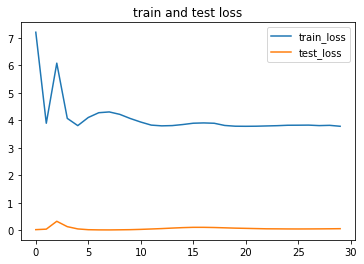

In [29]:
hist.plot(title="train and test loss")

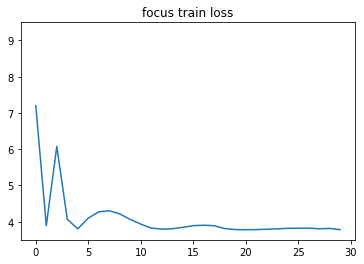

In [30]:
hist["train_loss"].plot(ylim=(3.5,9.5), title="focus train loss")

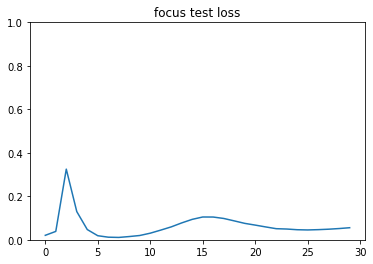

In [31]:
hist["test_loss"].plot(ylim=(0,1), title="focus test loss")

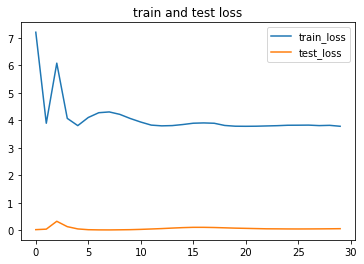

In [32]:
hist = pd.DataFrame(data={"train_loss": hist_train, "test_loss": hist_test})


graph = hist.plot(title="train and test loss")
graph.figure.savefig("artifacts/loss_fig.png")


## 6. mlflow logging  <a id="mlflow"></a>

In [51]:
with mlflow.start_run():
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("model_settings", model.eval())

#mlflow.pytorch.log_model(model, "model")
    
    mlflow.log_metric("epochs", n_epochs)
    
    for epoch, loss_value in enumerate(hist_train):
        mlflow.log_metric("loss_train", loss_value, step=epoch)
        
    for epoch, loss_value in enumerate(hist_test):
        mlflow.log_metric("loss_test", loss_value, step=epoch)
    
    mlflow.log_metric("training_duration", round(experiment_end - experiment_start, 2))

    mlflow.log_artifact("./artifacts/loss_fig.png")

    mlflow.end_run()

## 7. prediction <a id="pred"></a>

In [34]:

with torch.no_grad():
    
    test_seq = x_test[:1]
    preds = []
    
    for i in range(len(x_test)):
        
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, time_steps, 1).float()
        

In [35]:
deaths_true = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

In [36]:
deaths_pred = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

In [37]:
deaths_pred

array([62.89847168, 63.42853329, 63.63747197, 63.7223115 , 63.75118789,
       63.75417872])

In [38]:
deaths_true

array([1.3999998e+01, 1.2000002e+01, 2.4999998e+01, 2.9999990e+00,
       8.5681677e-08, 8.0000010e+00], dtype=float32)

In [39]:
vali_df = pd.DataFrame(data={"deaths_pred": deaths_pred, "deaths_true": deaths_true})

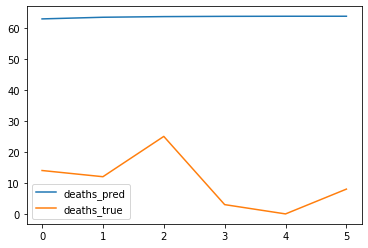

In [40]:
vali_df.plot()

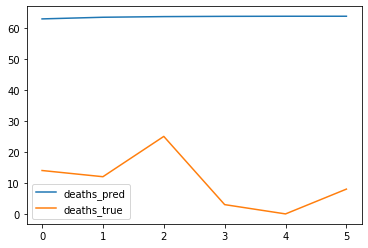

In [41]:
vali_df.plot().figure.savefig("artifacts/test.pdf")